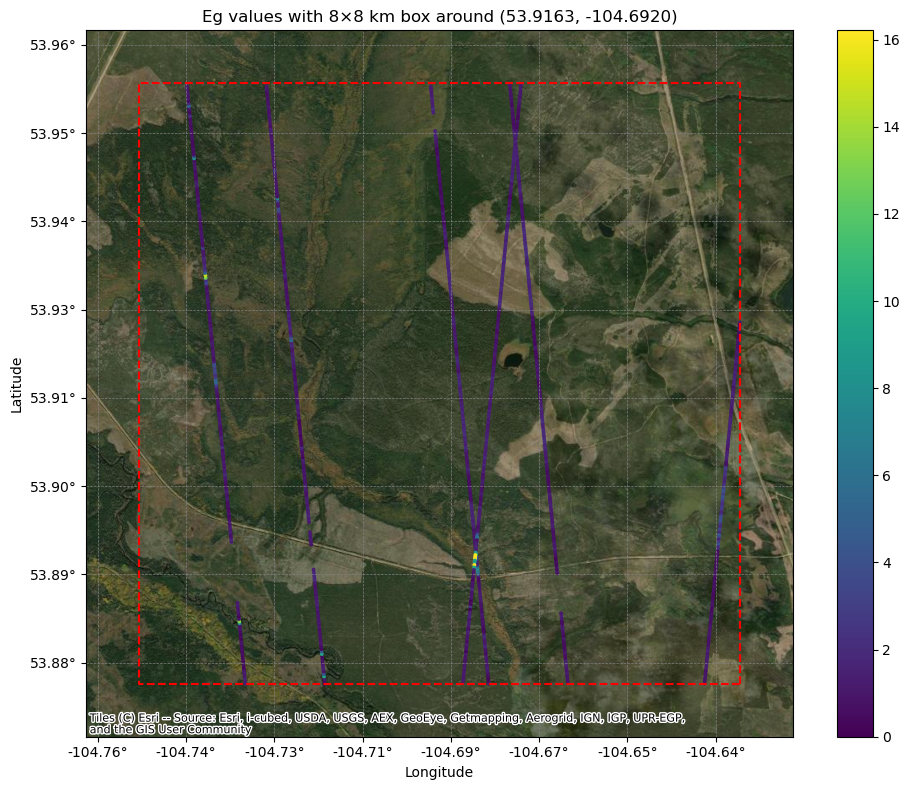

In [10]:
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from scripts.track_pairs import *
from scripts.show_tracks import *

def show_colorbar(cmap='viridis', vmin=0, vmax=6, label='Eg'):
    fig, ax = plt.subplots(figsize=(6, 0.5))
    fig.subplots_adjust(bottom=0.5)

    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    sm = cm.ScalarMappable(cmap=plt.colormaps[cmap], norm=norm)
    cbar = plt.colorbar(sm, cax=ax, orientation='horizontal')
    cbar.set_label(label, fontsize=10)
    plt.show()

def plot_on_folium(df, c='Eg', cmap='viridis', zoom_start=12, background = 'OpenStreetMap'):
    # Drop any invalid data just in case
    df = df.dropna(subset=['latitude', 'longitude', c])
    df = df[np.isfinite(df[c])]

    # Set vmin and vmax
    vmin = 0
    vmax = df[c].max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    colormap = plt.colormaps[cmap]

    # Center map on average coordinates
    lat_center = df['latitude'].mean()
    lon_center = df['longitude'].mean()
    m = folium.Map(location=[lat_center, lon_center], zoom_start=zoom_start, tiles='OpenStreetMap')

    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Esri Satellite',
        overlay=False,
        control=True
    ).add_to(m)

    # Plot each point
    for _, row in df.iterrows():
        color = colormap(norm(row[c]))
        hex_color = colors.to_hex(color)
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=2,
            color=hex_color,
            fill=True,
            fill_opacity=0.7
        ).add_to(m)

    return m

import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

def plot_static_map_with_box(df, coords, c='Eg', cmap='viridis', vmin=0, vmax=6, save='no'):
    lon_center, lat_center = coords
    km_to_deg_lat = 1 / 111  # degrees per km in latitude
    km_to_deg_lon = 1 / (111 * np.cos(np.radians(lat_center)))  # degrees per km in longitude

    # Compute the box size in degrees
    half_box_deg_lat = 4 * km_to_deg_lat
    half_box_deg_lon = 4 * km_to_deg_lon
    pad_deg_lat = 0.7 * km_to_deg_lat
    pad_deg_lon = 0.7 * km_to_deg_lon

    # Define the bounding box and padded extent
    box_geom = box(lon_center - half_box_deg_lon,
                   lat_center - half_box_deg_lat,
                   lon_center + half_box_deg_lon,
                   lat_center + half_box_deg_lat)

    extent = [lon_center - half_box_deg_lon - pad_deg_lon,
              lon_center + half_box_deg_lon + pad_deg_lon,
              lat_center - half_box_deg_lat - pad_deg_lat,
              lat_center + half_box_deg_lat + pad_deg_lat]

    # Convert DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(df.copy(), geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs="EPSG:4326")

    # Convert to Web Mercator for basemap
    gdf_web = gdf.to_crs(epsg=3857)
    box_web = gpd.GeoSeries([box_geom], crs="EPSG:4326").to_crs(epsg=3857)
    extent_web = gpd.GeoSeries([Point(x, y) for x, y in [
        (extent[0], extent[2]), (extent[1], extent[3])
    ]], crs="EPSG:4326").to_crs(epsg=3857).total_bounds

    fig, ax = plt.subplots(figsize=(10, 8))
    gdf_web.plot(ax=ax, column=c, cmap=cmap, markersize=3, legend=True, vmin=vmin, vmax=vmax)
    box_web.boundary.plot(ax=ax, color='red', linewidth=1.5, linestyle='--')

    ax.set_xlim(extent_web[0], extent_web[2])
    ax.set_ylim(extent_web[1], extent_web[3])
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    # Add axis gridlines and lat/lon labels
    ax.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5)
    from pyproj import Transformer

    # Transformer to go from Web Mercator (EPSG:3857) to WGS84 (EPSG:4326)
    transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
    
    # Format axis ticks to show degrees
    def format_lon(x, _): 
        lon, _ = transformer.transform(x, 0)
        return f"{lon:.2f}°"
    
    def format_lat(y, _): 
        _, lat = transformer.transform(0, y)
        return f"{lat:.2f}°"
    
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_lon))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_lat))

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # ax.set_axis_off()
    plt.title(f"{c} values with 8×8 km box around ({lat_center:.4f}, {lon_center:.4f})")
    plt.tight_layout()
    if save != 'no':
        plt.savefig(f'{save}.jpg')
    plt.show()


dirpath = '../scratch/data/old_jack_pine/'
all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
coords = (-104.6920, 53.9163) # old_jack_pine ALT 451
# coords = (-89.5373, 46.2339) # underc ALT 520
# coords = (-90.0791, 45.8060) # willow creek ALT 521

# ax = plt.gca()
big_df = show_tracks([all_ATL03[i] for i in [23,21,20]], [all_ATL08[i] for i in [23,21,20]], coords, altitude=451, c='Eg', CBAR=None, gtx=[1,3,5], landcover='forest',rebinned=30)

# print(big_df)

vmin = 0
vmax = big_df['Eg'].max()

# show_colorbar(cmap='viridis', vmin=vmin, vmax=vmax, label='Eg')

# map_ = plot_on_folium(big_df, c='Eg', background = 'OpenStreetMap')
# map_.save('icesat_ojp_segments.html')
# from IPython.display import display
# display(map_)

plot_static_map_with_box(big_df, coords, c='Eg', cmap='viridis', vmin=vmin, vmax=vmax)#, save='old_jack_pine_nonsnowy')